In [46]:
import sys
import os
import json

import torch
import numpy as np
import matplotlib.pyplot as plt

import time
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [47]:
import torch
import torch.onnx as onnx
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [48]:
import tkinter as tk
from tkinter import *

In [49]:
from PIL import Image, ImageTk

In [51]:
import pathlib
from pathlib import Path
from functools import partial

In [52]:
#Initialize Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [53]:
#Create training and test data loader for MNIST
training_data = torchvision.datasets.MNIST(
    '/files/',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                                             )
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [54]:
#Setup numerous variables for training and testing
train_dataloader = DataLoader(training_data, 64, shuffle=True)
epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10
batch_size = 64

#Creates a random seed
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [55]:
#Use a pretrained model
pretrained_model = "model_weights.pth"

In [56]:
#Sets up Epsilons to run through for testing
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

In [57]:
#Attempts to use cuda if available
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net()
model.load_state_dict(torch.load(pretrained_model))
model2 = Net().to(device)

#Creates loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

CUDA Available:  False


In [58]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [59]:
#Tests neural network on FGSM of various epsilons and saves images
def test(model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        # get the index of the max log-probability
        init_pred = output.max(1, keepdim=True)[1]

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max log-probability
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 50):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 500:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append(
                    (init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon,
          correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [60]:
#Sets model to evaluation and creates arrays for images to be saved to
accuracies = []
examples = []
model.eval()

#Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

#Saves each epsilon to a different letter. This probably should be changed for readability
a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 9871 / 10000 = 0.9871
Epsilon: 0.05	Test Accuracy = 9410 / 10000 = 0.941
Epsilon: 0.1	Test Accuracy = 8321 / 10000 = 0.8321
Epsilon: 0.15	Test Accuracy = 6446 / 10000 = 0.6446
Epsilon: 0.2	Test Accuracy = 4215 / 10000 = 0.4215
Epsilon: 0.25	Test Accuracy = 2330 / 10000 = 0.233
Epsilon: 0.3	Test Accuracy = 1072 / 10000 = 0.1072


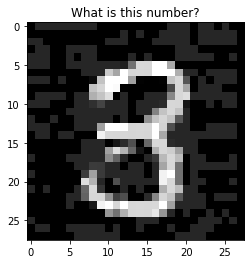

In [61]:
#Initializes an image for GUI
label, new_label, image, = d[0]
plt.title("What is this number?")
plt.imshow(image, cmap="gray")
plt.savefig('saved_figure.png')

In [62]:
#Generates an image of epsilon 0.2
def generateNewImage(count):
    label, new_label, image, = d[count]
    plt.title("What is this number?")
    plt.imshow(image, cmap="gray")
    plt.savefig('saved_figure2.png')
    return label
    

In [63]:
#Initializes the height and width of image for GUI
HEIGHT = 200
WIDTH = 200
IMAGE_HEIGHT = 200
IMAGE_WIDTH = 200

In [64]:
#Variables initialized for my user path. Can be changed for different user
x = "/Users/Alex Vogt/Desktop/work-visualization/MNIST_Alex/saved_figure.png" 
x2 = "/Users/Alex Vogt/Desktop/work-visualization/MNIST_Alex/saved_figure2.png" 
x3 = "/Users/Alex Vogt/Desktop/work-visualization/MNIST_Alex/saved_figure3.png" 

In [65]:
#Count of image displayed currently and count guessed correctly in the GUI
correctCount = 0
totalCount = 0

In [66]:
#Function to display perturbed images for user based on user input
def numClick():
    currNum = a.get()
    temp = 0
    # curr = len(d) - 1
    curr = 499
    images = []
    while temp < 6 and curr > 0:
        label, new_label, image = d[curr]
        if label == int(currNum):
            images.append(image)
            temp = temp + 1
        curr = curr - 1
    
    for currIterator in range(6):
        currImage = images[currIterator]
        plt.imshow(currImage, cmap="gray")
        plt.savefig('saved_figure3.png')

        image1 = Image.open(x3)
        test = ImageTk.PhotoImage(image1)
        label1 = tk.Label(number_frame, image=test)
        label1.image = test
        if currIterator < 3:
            label1.grid(row=3, column=currIterator, sticky="nsew", padx=2, pady=2)
        else:
            label1.grid(row=4, column=(currIterator - 3), sticky="nsew", padx=2, pady=2)   

In [67]:
#Function for button for user guess
def myClick():
    global totalCount
    global label
    currCount = correctCount
    newLabel = label
    currNum = e.get()
    if (int(currNum) == newLabel):
        currCount = currCount + 1
        myLabel = Label(output_frame, text="Correct!")
        myLabel.grid(row=0, column=2, rowspan=2, sticky="nsew", padx=2, pady=2)
    else: 
        myLabel2 = Label(output_frame, text="Incorrect")
        myLabel2.grid(row=0, column=2, rowspan=2, sticky="nsew", padx=2, pady=2)
    #Create new image
    label = generateNewImage(totalCount)
    image1 = Image.open(x2)
    test = ImageTk.PhotoImage(image1)
    label1 = tk.Label(image_frame, image=test)
    label1.image = test
    label1.grid(row=0, column=0, sticky="nsew", padx=2, pady=2)

    #Generates new model prediction
    stringModel = "Model Prediction: "
    ga, answer, gar, = d[totalCount]
    convAnswer = str(answer)
    stringModel = stringModel + convAnswer
    def_label = tk.Label(visual_aid_frame, text=stringModel)
    def_label.pack(padx=10, pady=5, fill=tk.BOTH)
    
    #Label(image_frame, image=test).grid(row=1, column=0, sticky="nsew", padx=2, pady=2)
    totalCount = totalCount + 1

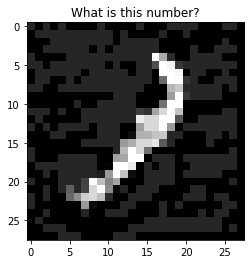

In [68]:
#GUI
root = Tk()
root.title("Human Testing of Adversarial Training")

#Setup frames
# global image_frame
image_frame = tk.Frame(root, background="#FFF0C1", bd=1, relief="sunken")
input_frame = tk.Frame(root, background="#D2E2FB", bd=1, relief="sunken")
visual_aid_frame = tk.Frame(root, background="#CCE4CA", bd=1, relief="sunken")
output_frame = tk.Frame(root, background="#F5C2C1", bd=1, relief="sunken")
number_frame = tk.Frame(root, background="#0000FF.", bd=1, relief="sunken")
image_frame.grid(row=0, column=0, sticky="nsew", padx=2, pady=2)
input_frame.grid(row=1, column=0, sticky="nsew", padx=2, pady=2)
visual_aid_frame.grid(row=0, column=1, rowspan=2, sticky="nsew", padx=2, pady=2)
output_frame.grid(row=0, column=2, rowspan=2, sticky="nsew", padx=2, pady=2)
number_frame.grid(row=0, column=3, rowspan=2, sticky="nsew", padx=2, pady=2)


#Configure frames
root.grid_rowconfigure(0, weight=3)
root.grid_rowconfigure(1, weight=2)
root.grid_columnconfigure(0, weight=3)
root.grid_columnconfigure(1, weight=2)
root.grid_columnconfigure(2, weight=2)
root.grid_columnconfigure(3, weight=2)


# Create a photoimage object of the image in the path
image1 = Image.open(x)
test = ImageTk.PhotoImage(image1)
Label(image_frame, image=test).grid(row=0, column=0, sticky="nsew", padx=2, pady=2)


#Creates entry box for user guess
e = Entry(input_frame, width=50)
e.grid(row=0, column=0, sticky="nsew", padx=2, pady=2)

#Adds a Button
myButton = Button(input_frame, text="Click Me!", pady=50, command=partial(myClick))
myButton.grid(row=1, column=0, sticky="nsew", padx=2, pady=2)

#Visual Aid
stringModel = "Model Prediction: "
ga, answer, gar, = d[totalCount]
convAnswer = str(answer)
stringModel = stringModel + convAnswer
def_label = tk.Label(visual_aid_frame, text=stringModel)
def_label.pack(padx=10, pady=5, fill=tk.BOTH)

#Show number based on user input
num_label = tk.Label(number_frame, text="What number would you like to see perturbed images of?")
num_label.grid(row=0, column=0, sticky="nsew", padx=2, pady=2)

a = Entry(number_frame, width=50)
a.grid(row=1, column=0, sticky="nsew", padx=2, pady=2)

myButton = Button(number_frame, text="Click Me!", pady=50, command=partial(numClick))
myButton.grid(row=2, column=0, sticky="nsew", padx=2, pady=2)


# Position image
root.mainloop()
